In [104]:
## custom
from utils import utils, vis
# from utils import poly_point_isect as bo   ##bentley-ottmann sweep line

import criteria as C
import quality as Q
from gd2 import GD2

## third party
import networkx as nx
import pandas as pd
from PIL import Image
from natsort import natsorted


## sys
import random
from glob import glob
import math
from collections import defaultdict
import itertools
import time
import pickle as pkl

## numeric
import numpy as np
from scipy.sparse import csgraph
from scipy.sparse import csr_matrix
import scipy.io as io

import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from IPython.display import set_matplotlib_formats
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
set_matplotlib_formats('retina')
%config InlineBackend.figure_format = 'retina'


## Training

In [306]:
G = nx.balanced_tree(2,9)
len(G)

1023

start


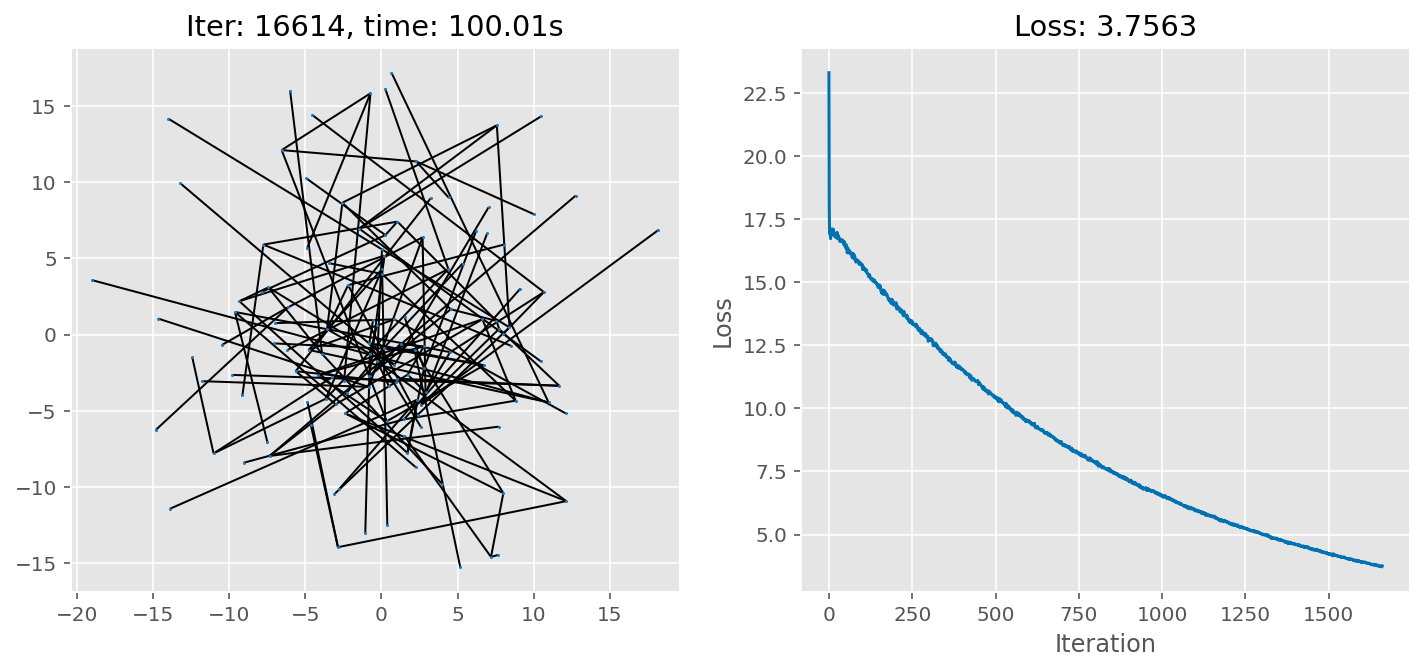

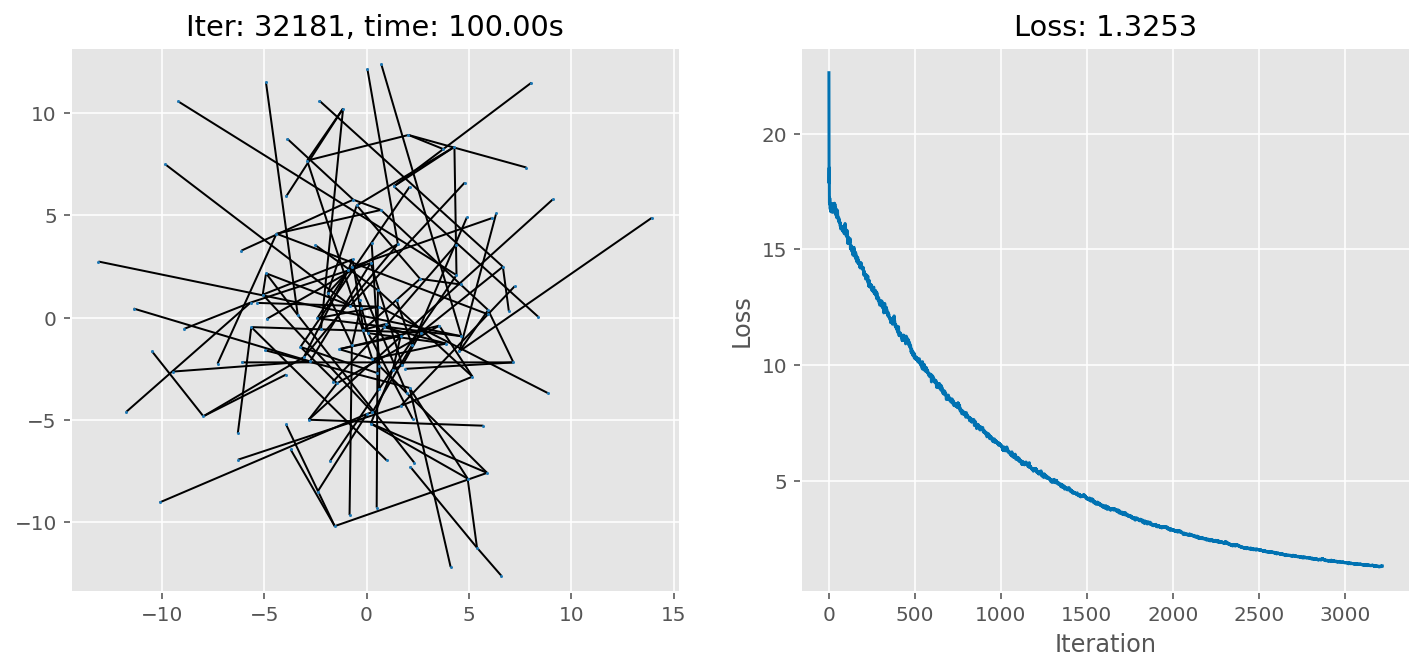

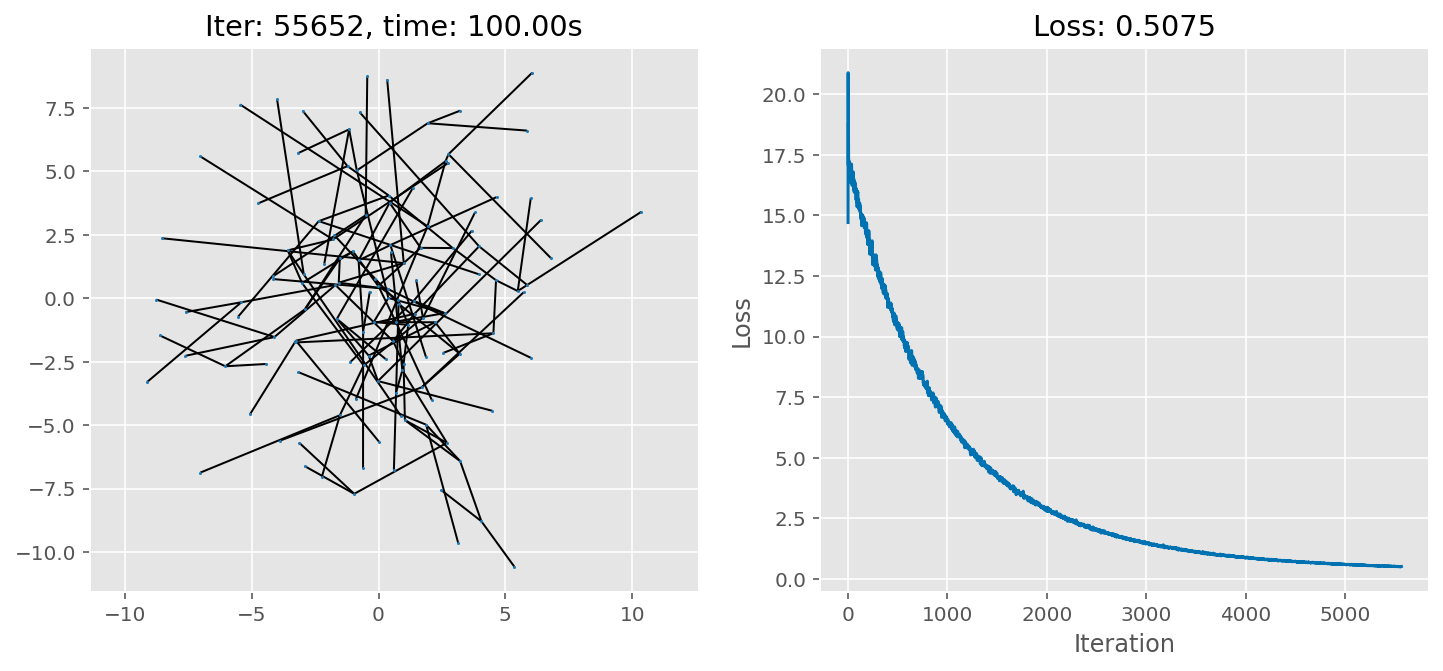

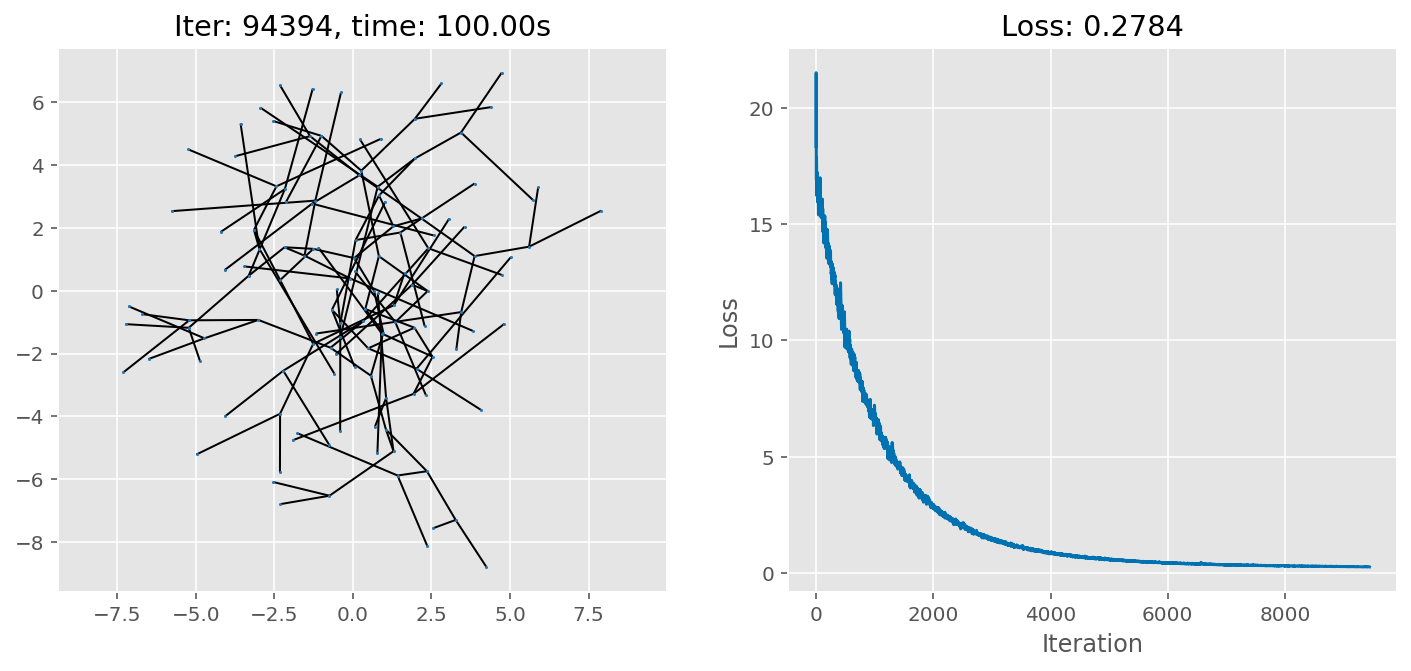

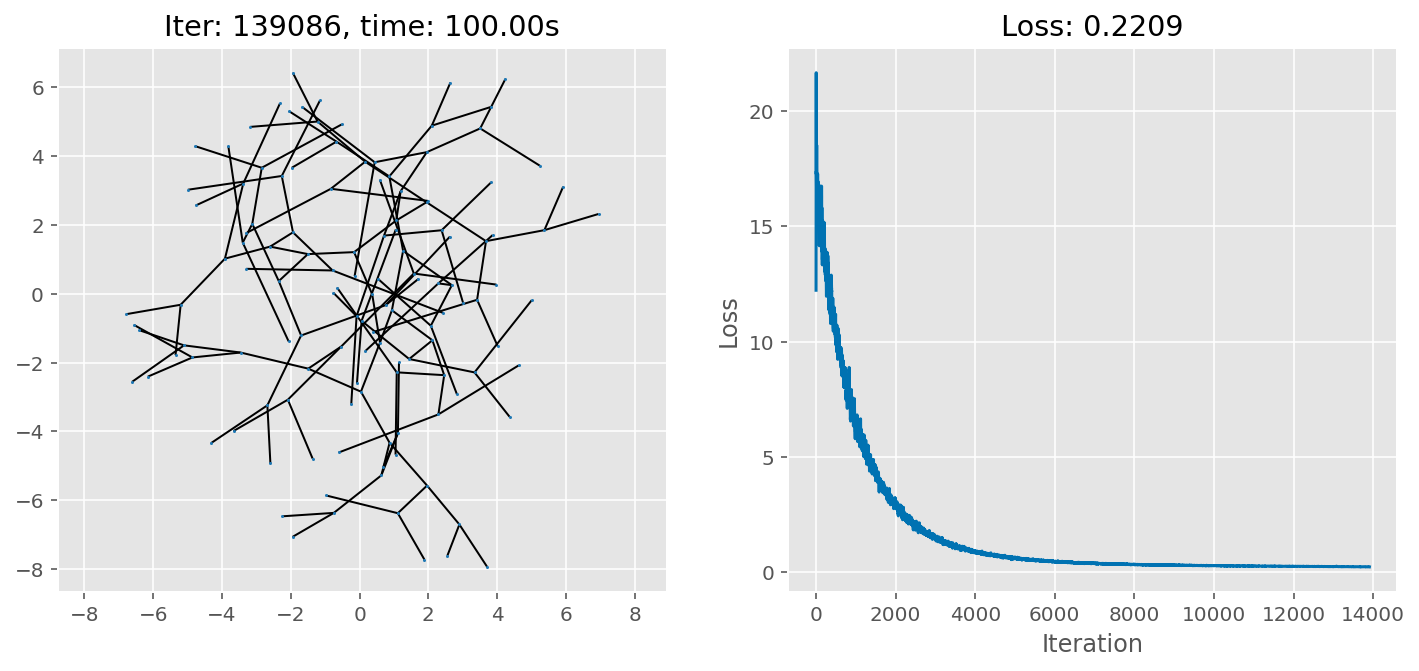

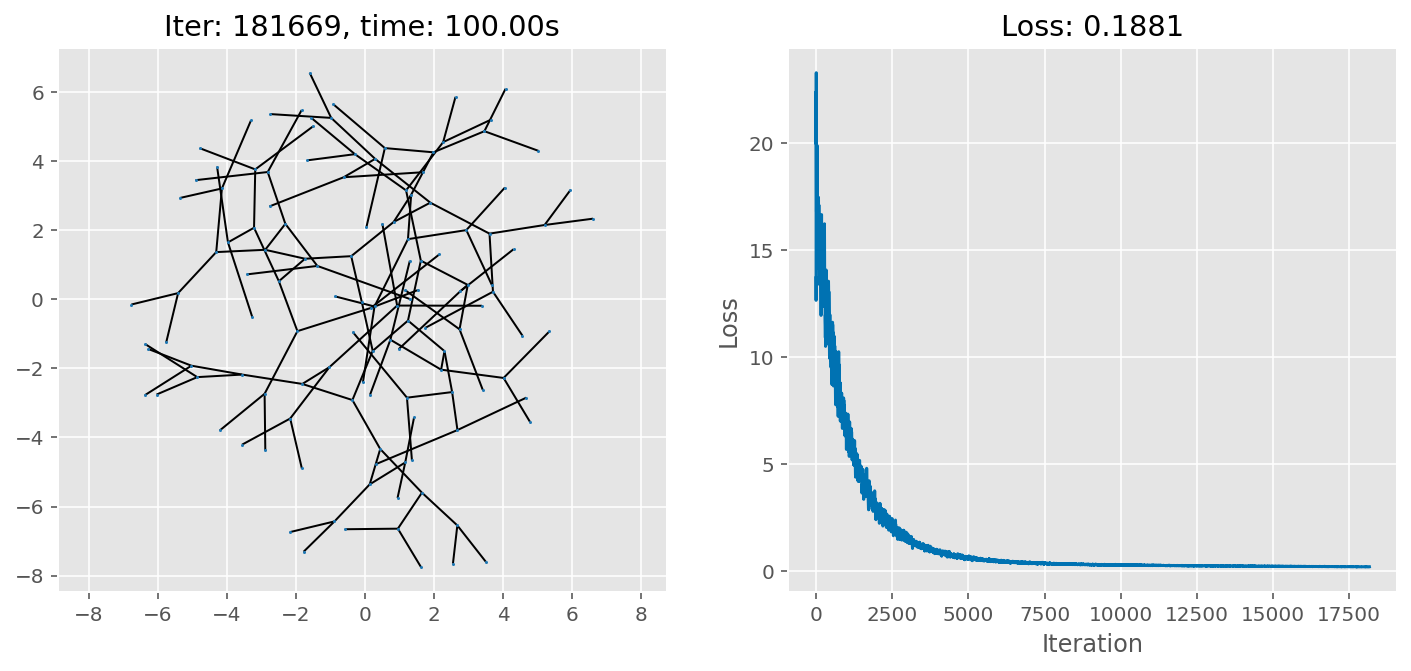

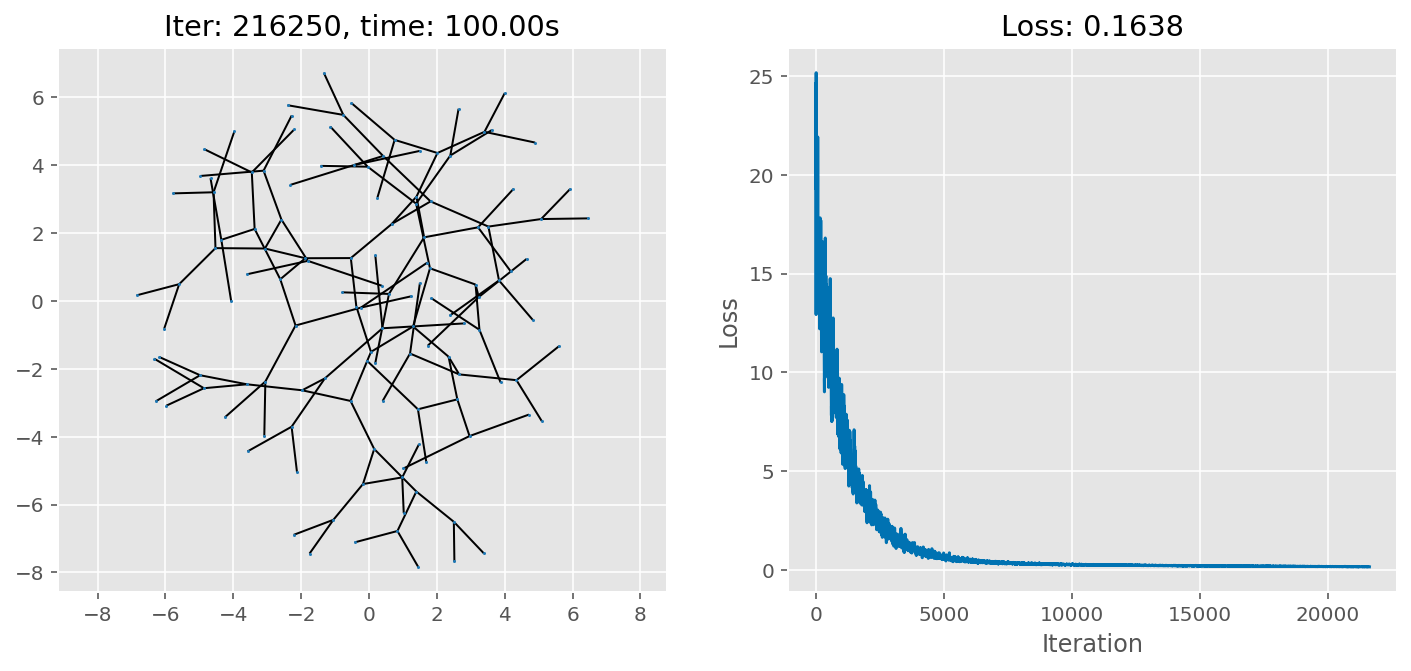

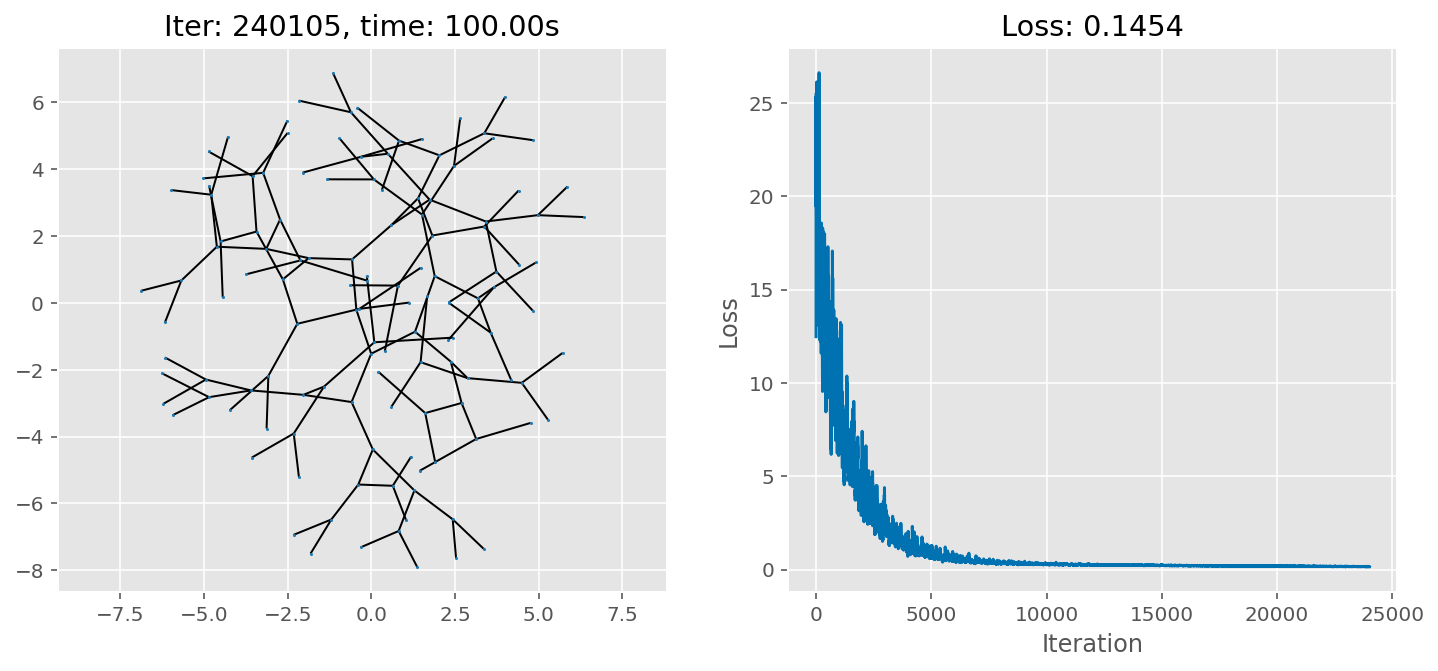

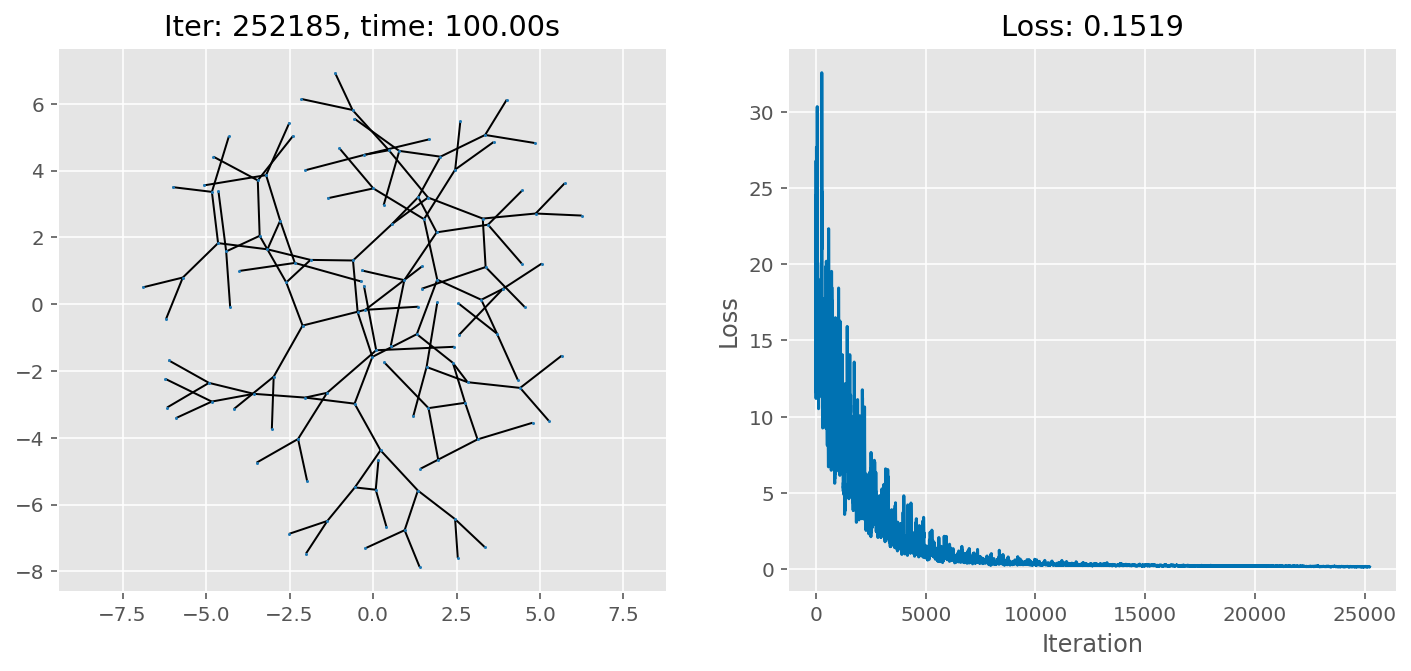

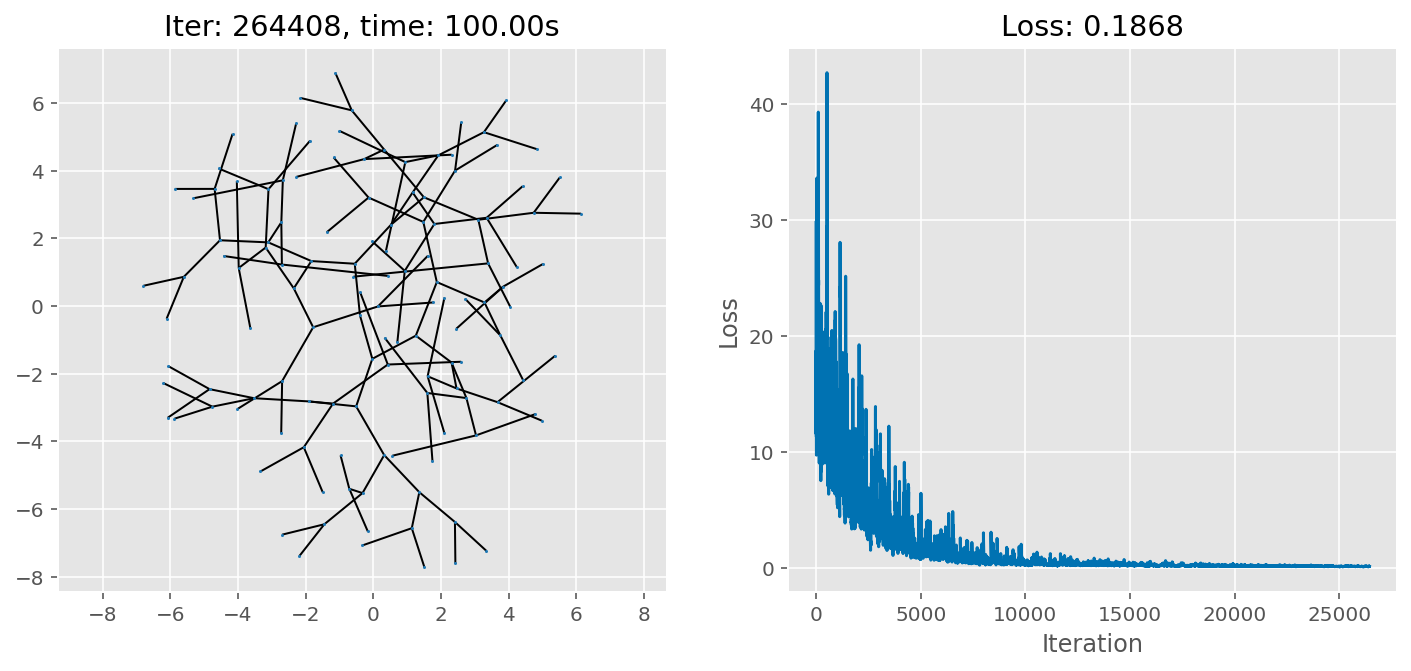


analysis/sample_size/tree-2-6-SGD-lr=0.01-t1636598370.pkl


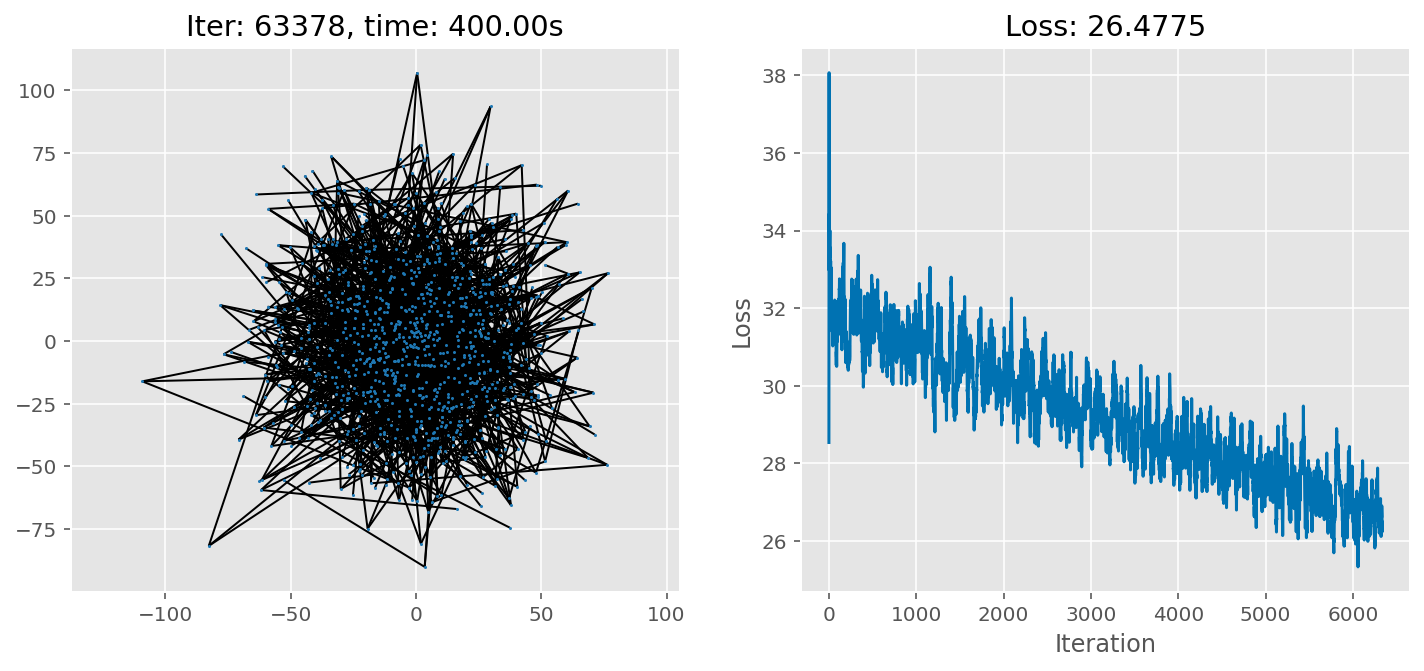

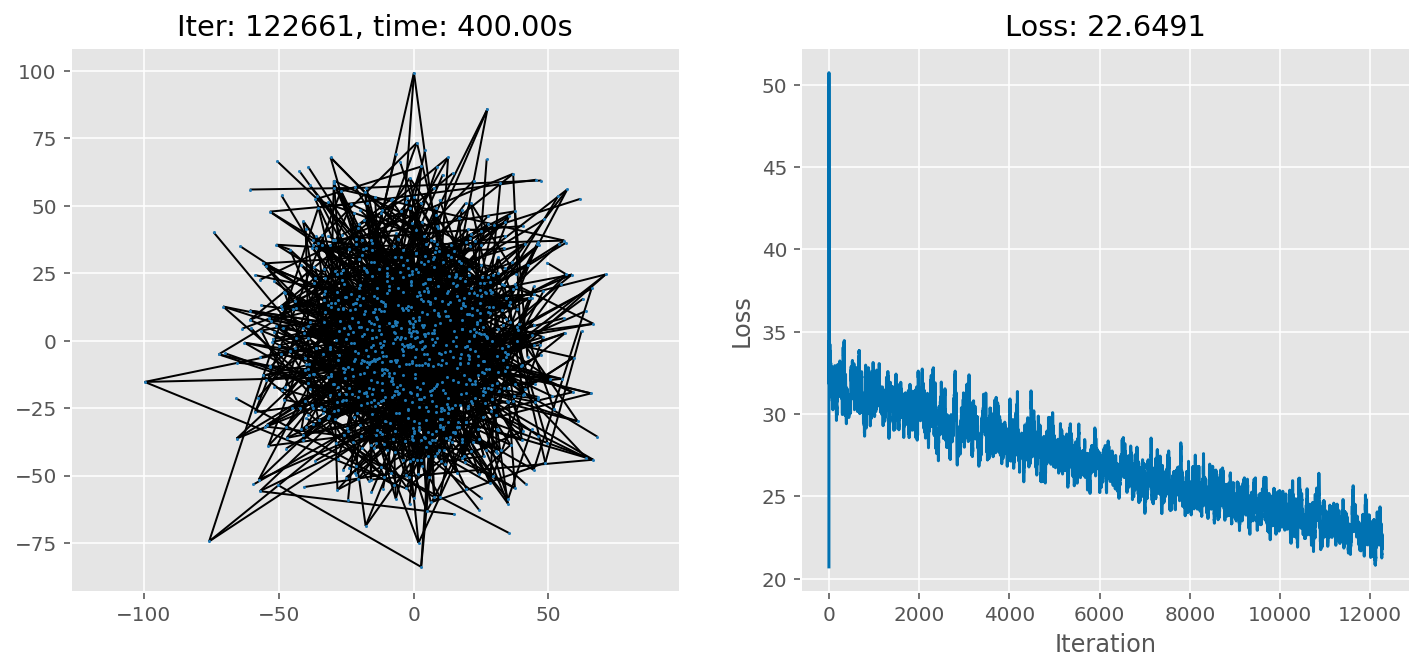

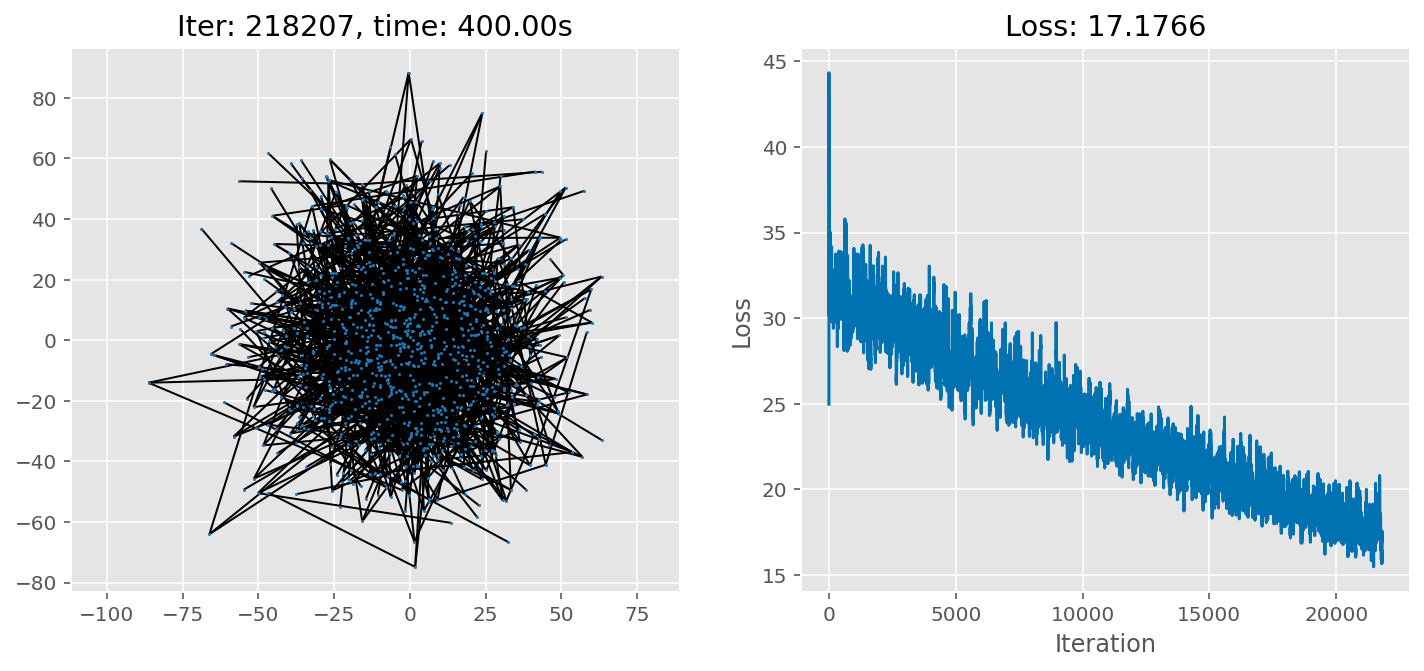

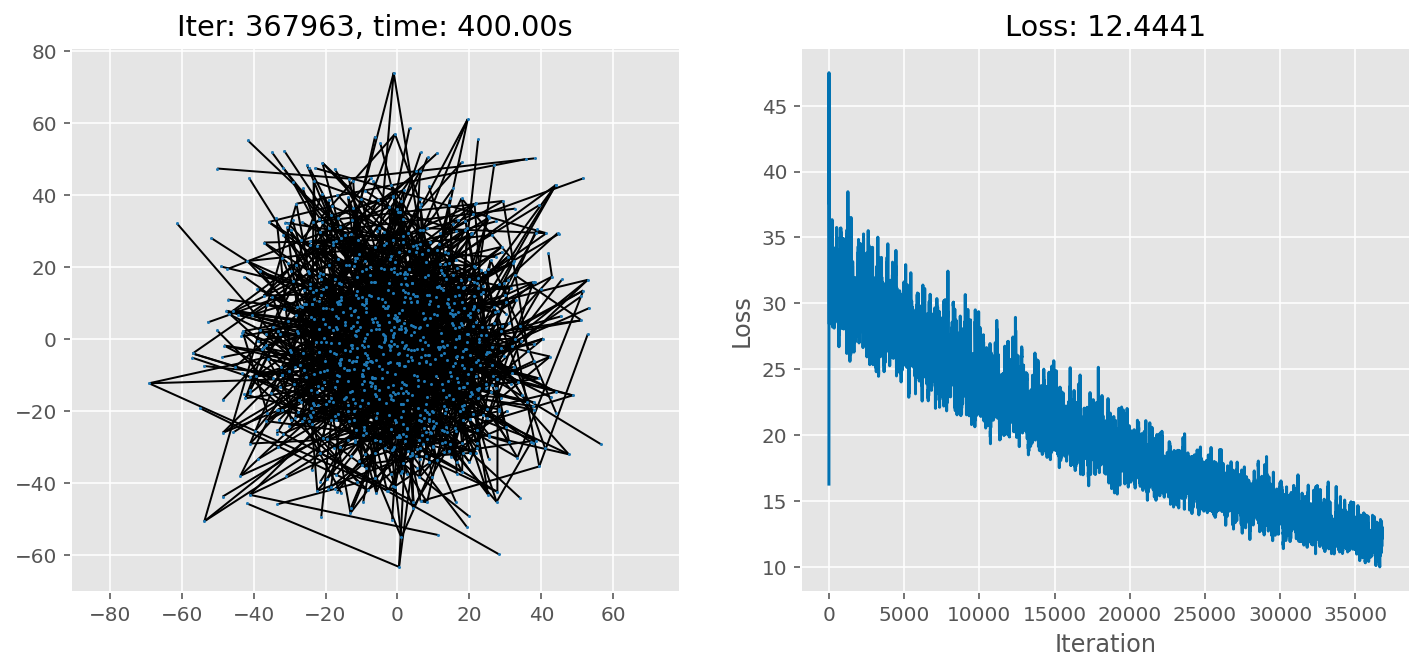

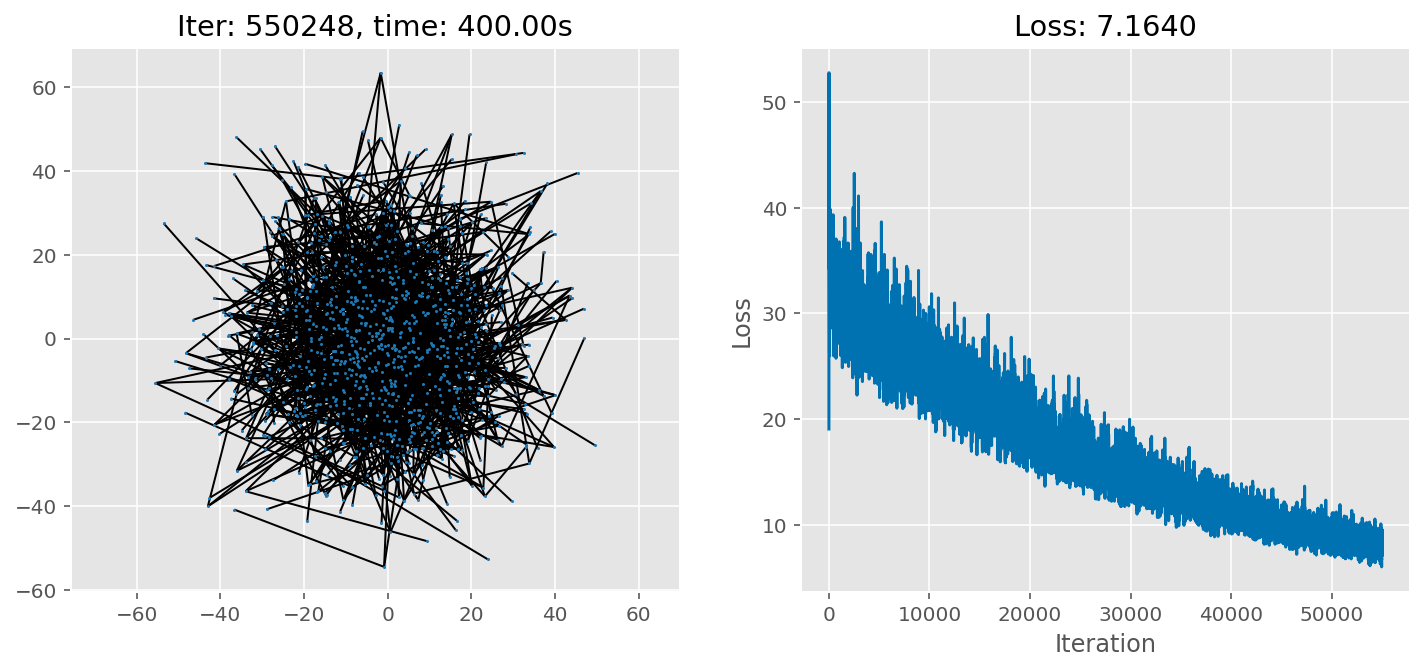

Epoch 20002: reducing learning rate of group 0 to 9.0000e-03.



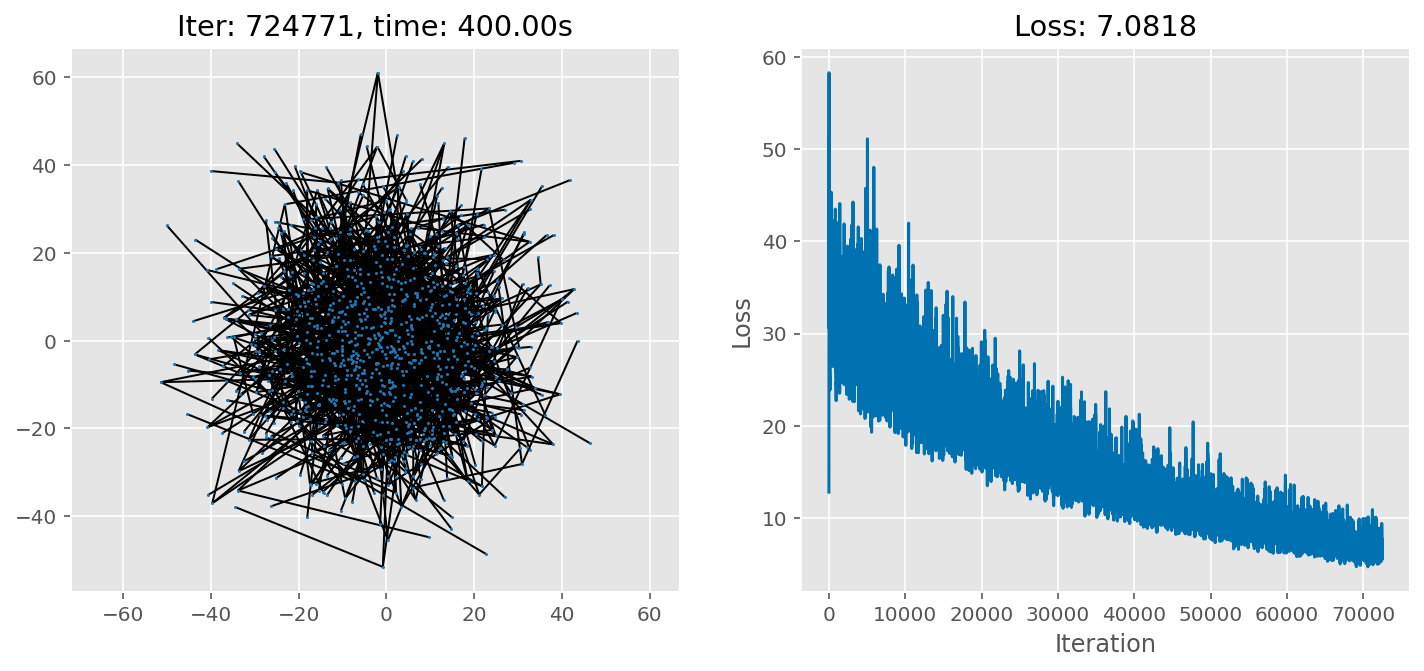

Epoch 20002: reducing learning rate of group 0 to 9.0000e-03.



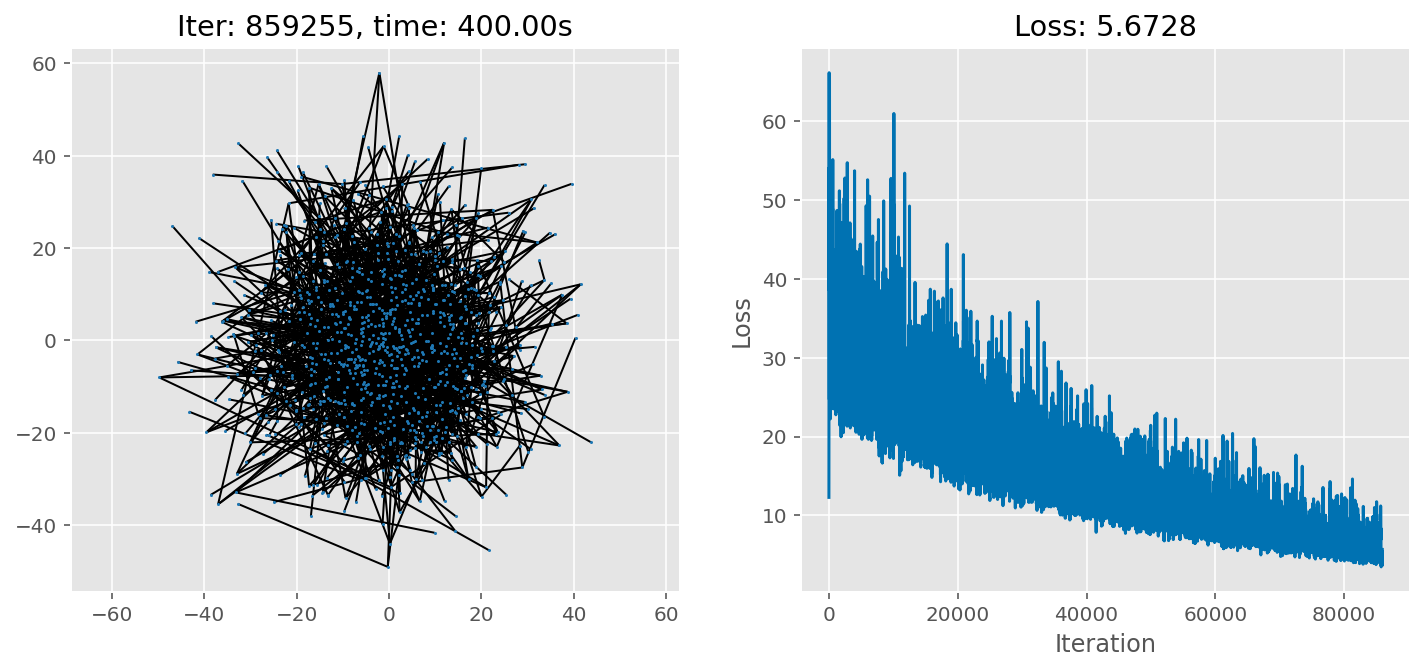

Epoch 20002: reducing learning rate of group 0 to 9.0000e-03.



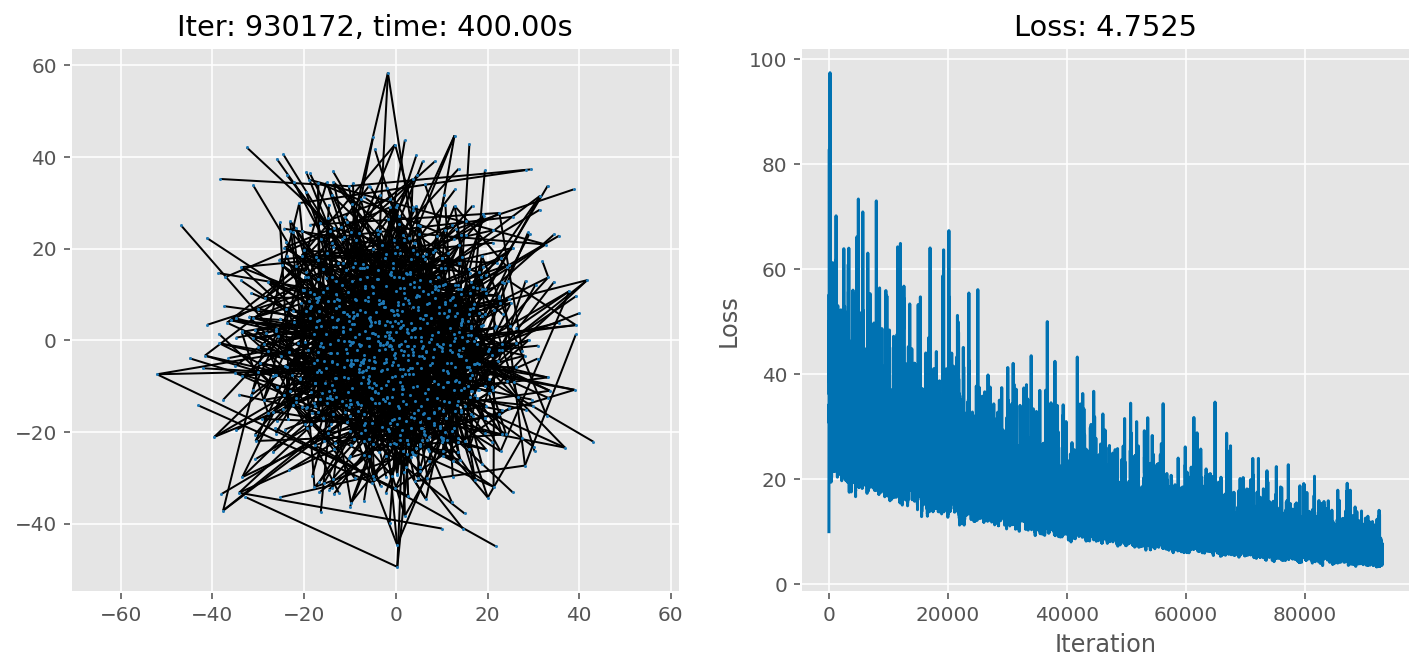

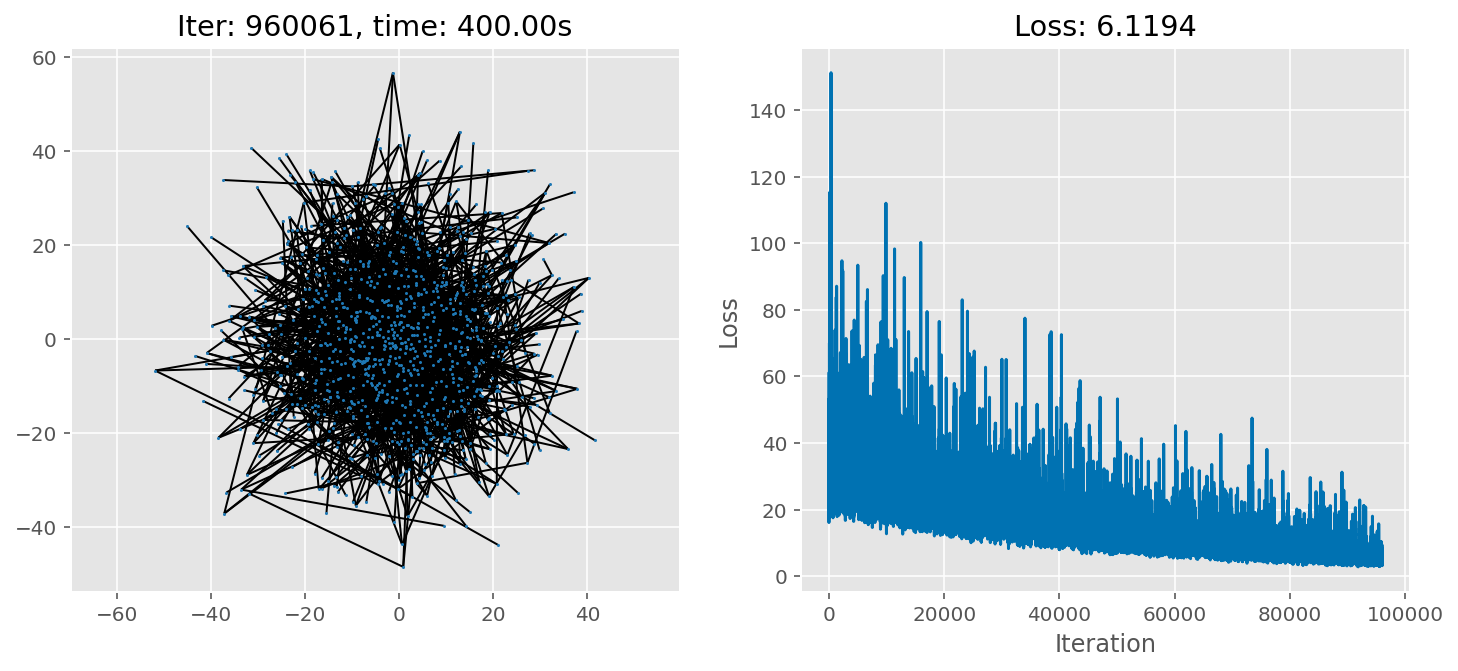

Epoch 20002: reducing learning rate of group 0 to 9.0000e-03.
Epoch 40003: reducing learning rate of group 0 to 8.1000e-03.



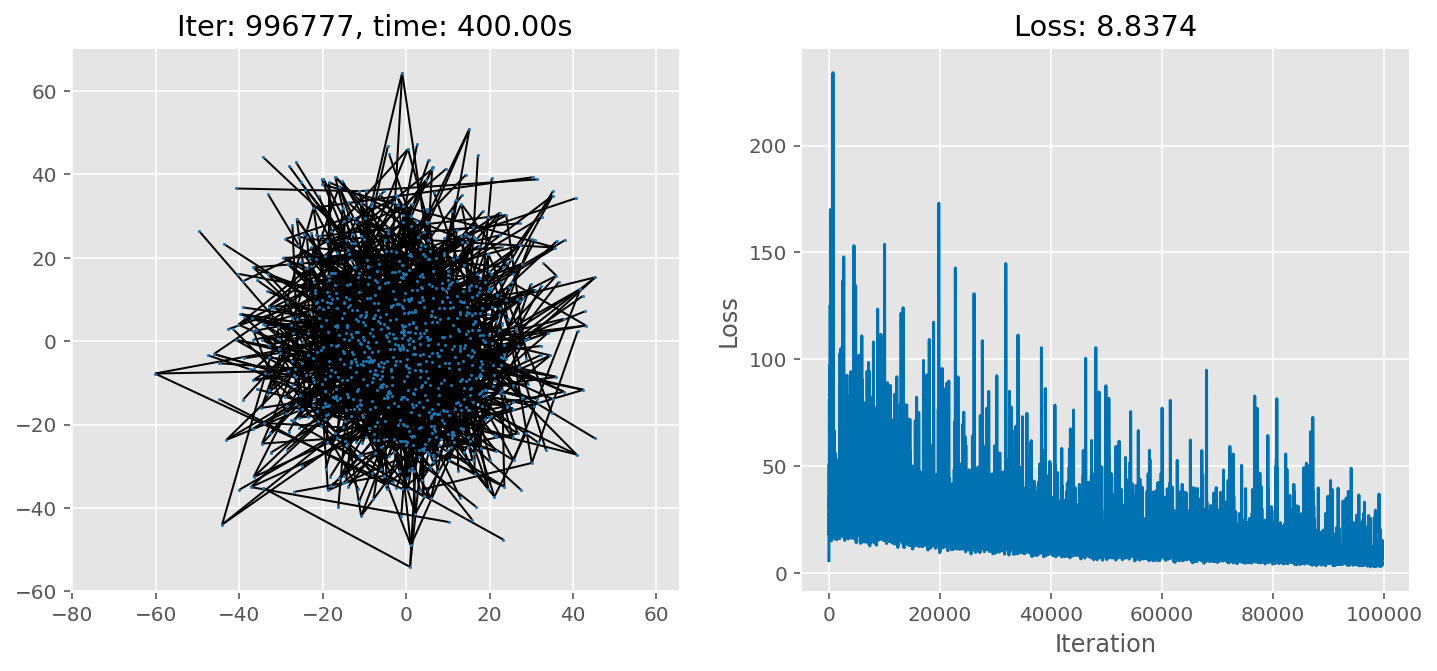


analysis/sample_size/tree-2-9-SGD-lr=0.01-t1636603048.pkl



In [225]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

print('start')

## choose one criterion
criterion = 'stress'
sample_sizes = [1,2,4,8,16,32,64,128,256,512]
sample_sizes = sample_sizes[::-1]

criteria_weights = dict(
    stress=1,
    ideal_edge_length=0.1,
    neighborhood_preservation=1,
    crossings=0.9,
    crossing_angle_maximization=0.1,
    aspect_ratio=0.1,
    angular_resolution=0.1,
    vertex_resolution=0.1,
    gabriel=0.5,
)


# for lr in [0.1, 0.3, 1]:##SGD
# for lr in [1,]:##SGD
# for lr in [0.3,]:##SGD

for lr in [0.01]:#, 0.05, 0.15]:##ADAM


    # for depth, time_limit in tqdm(list(zip([5,6,7,8,9,10,11], [50,100,200,300,400,500,600]))):
#     for depth, time_limit in tqdm(list(zip([6, 9], [100, 400]))): ## SGD, larger-lr ADAM
    for depth, time_limit in tqdm(list(zip([6, 9], [300, 900]))): ## ADAM lr=0.01
        G = nx.balanced_tree(2,depth)
        graph_str = f'tree-2-{depth}'

    # for side_length, time_limit in tqdm(list(zip([4,8,16,32,64,128],[25,50,100,200,600,600]))):
    #     G = nx.grid_2d_graph(16,side_length)
    #     graph_str = f'grid-16-{side_length}'


        
        dfs = {}

        for sample_size in tqdm(sample_sizes):
            
            seed = 1337
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)

    
            gd = GD2(G)

            result = gd.optimize(
                criteria_weights={criterion: criteria_weights[criterion]}, 
                sample_sizes={criterion: sample_size},
                evaluate={criterion},

                max_iter=int(1e9), 
                time_limit=time_limit, ##sec
    #             evaluate_interval=5000, evaluate_interval_unit='iter',
                evaluate_interval=0.5, evaluate_interval_unit='sec',

                vis_interval=-200000//20,
                clear_output=False,

                criteria_kwargs = dict(
                    aspect_ratio=dict(target=[1,1]),
                ),
    #             optimizer_kwargs = dict(mode='Adam', lr=0.05), ## trees
    #             optimizer_kwargs = dict(mode='SGD', lr=2),
                optimizer_kwargs = dict(mode='SGD', lr=lr), ## trees
    #             optimizer_kwargs = dict(mode='SGD', lr=0.2), ## grids

                scheduler_kwargs = dict(verbose=True),
            )


            dfs[sample_size] = pd.DataFrame({
                'time': [x['time'] for x in result['qualities_by_time']], 
                criterion: [x['qualities'][criterion] for x in result['qualities_by_time']]
            })


            pos = gd.pos.detach().numpy()
            pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
            vis.plot(
                gd.G, pos_G,
                gd.loss_curve, 
                result['iter'], result['runtime'],
                show=True, save=False
            )

        t = int(time.time())
#         fn_out = f'analysis/sample_size/{graph_str}-SGD-lr={lr}-t{t}.pkl'
        fn_out = f'analysis/sample_size/{graph_str}-ADAM-lr={lr}-t{t}.pkl'
        print(fn_out)
        with open(fn_out, 'wb') as f:
            pkl.dump(dfs, f)
    





## Plot

In [258]:
fns = natsorted(glob('analysis/sample_size/tree-2-9-SGD*.pkl'))
fns

['analysis/sample_size/tree-2-9-SGD-lr=0.1-t1636517811.pkl',
 'analysis/sample_size/tree-2-9-SGD-lr=0.3-t1636536037.pkl',
 'analysis/sample_size/tree-2-9-SGD-lr=1-t1636531721.pkl',
 'analysis/sample_size/tree-2-9-SGD-lr=2-t1636523531.pkl']

In [247]:
fns = [
    fn for fn in natsorted(glob('analysis/sample_size/tree-2-6-ADAM*.pkl')) 
    if int(fn.split('-t')[-1].split('.')[0]) >= 1636513133
]
fns
# natsorted(glob('analysis/sample_size/grid*.pkl')) 

['analysis/sample_size/tree-2-6-ADAM-lr=0.01-t1636598370.pkl',
 'analysis/sample_size/tree-2-6-ADAM-lr=0.05-t1636527456.pkl',
 'analysis/sample_size/tree-2-6-ADAM-lr=0.15-t1636530482.pkl']

In [110]:
# fns = [
#     fn for fn in natsorted(glob('analysis/sample_size/tree*.pkl'), reverse=True) 
# #     if int(fn.split('-t')[-1].split('.')[0]) >= 1635422621
# #     if int(fn.split('-t')[-1].split('.')[0]) >= 1635557143
# #     if int(fn.split('-t')[-1].split('.')[0]) >= 1635701887
#     if int(fn.split('-t')[-1].split('.')[0]) >= 1635733815
# ]

fns = [
    fn for fn in natsorted(glob('analysis/sample_size/grid*.pkl')) 
#     if int(fn.split('-t')[-1].split('.')[0]) >= 1635422621
#     if int(fn.split('-t')[-1].split('.')[0]) >= 1635781125
    if int(fn.split('-t')[-1].split('.')[0]) >= 1635862413
]

# fns = natsorted(glob('analysis/sample_size/tree*')) 
fns

['analysis/sample_size/grid-16-4-t1635862413.pkl',
 'analysis/sample_size/grid-16-8-t1635862935.pkl',
 'analysis/sample_size/grid-16-16-t1635863981.pkl',
 'analysis/sample_size/grid-16-32-t1635866082.pkl',
 'analysis/sample_size/grid-16-64-t1635872400.pkl',
 'analysis/sample_size/grid-16-128-t1635878974.pkl']

In [278]:
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

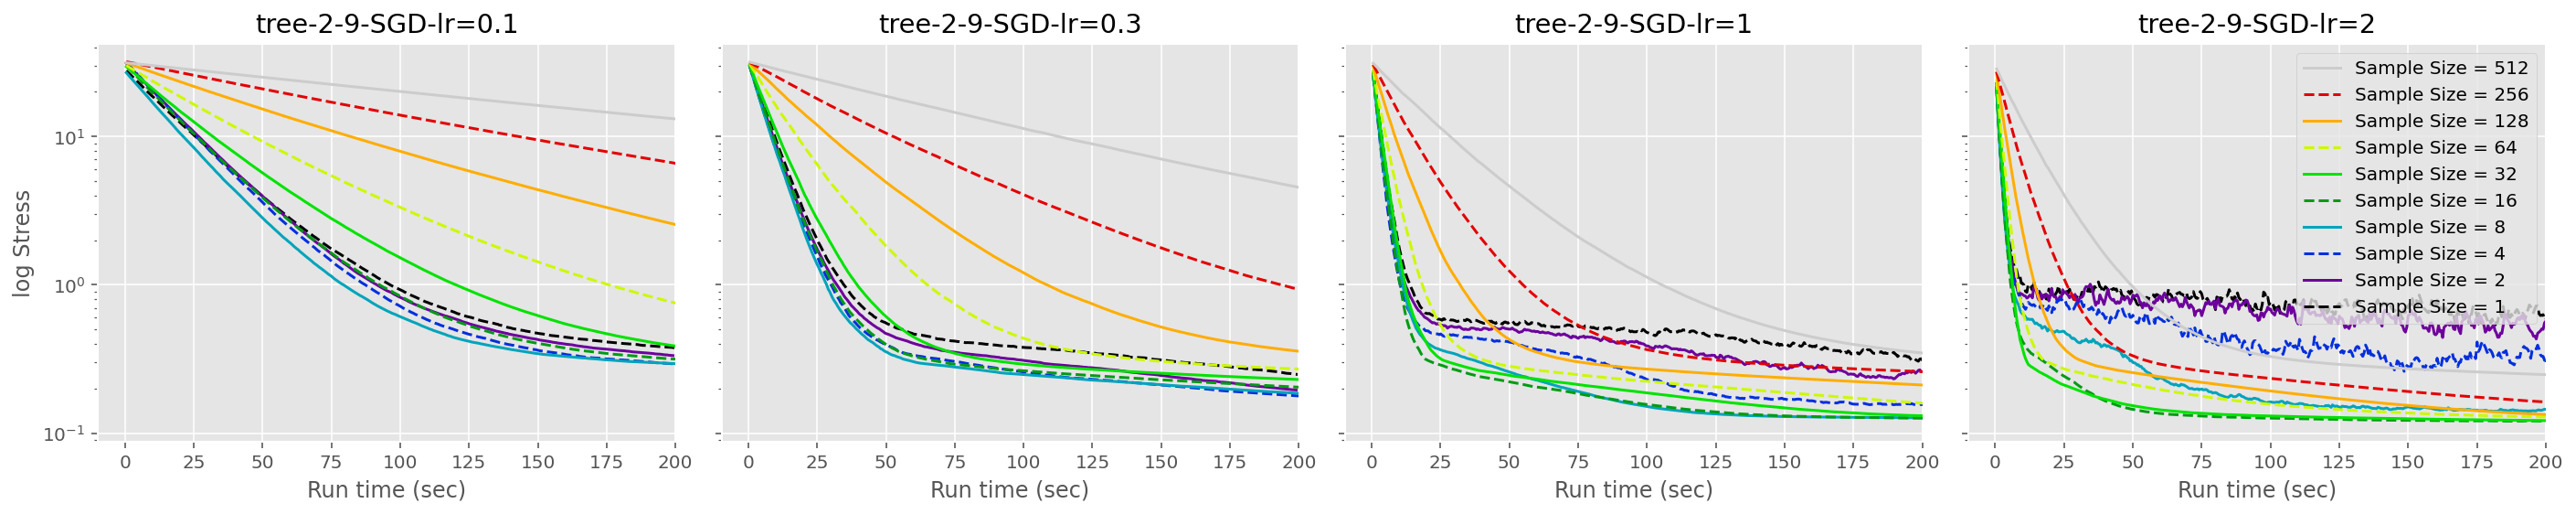

In [303]:
# cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('nipy_spectral')
# cm = plt.cm.get_cmap('Spectral')
# cm = plt.cm.get_cmap('tab10')
# cm = plt.cm.get_cmap('coolwarm')

# for fn_in in natsorted(glob('analysis/sample_size/tree*')):
fig = plt.figure(figsize=[6*len(fns), 4])
gs = GridSpec(1, len(fns), wspace=0.08)
for i, fn_in in enumerate(fns):
    graph_str = fn_in.split('/')[-1].split('-t')[0]
    with open(fn_in, 'rb') as f:
        dfs = pkl.load(f)
    criterion = next(iter(dfs.values())).columns[1]
    max_sample_size = max(dfs.keys())
    
#     t_max = dfs[1]['time'].iloc[-1]
#     plt.figure(figsize=[8,4])
#     if 'tree-2-9' in fn_in:
#         xlims = [(-1, t_max*0.1), (t_max*0.9, t_max)]
#     elif 'tree-2-6' in fn_in:
#         xlims = [(-1, t_max*0.05), (t_max*0.9, t_max)]
#     bax = brokenaxes(
#         xlims=xlims, wspace=0.15
#     )

    if i==0:
        ax = ax0 = plt.subplot(gs[0,i])
    else:
        ax = plt.subplot(gs[0,i], sharey=ax0)
    
    for j, [sample_size, df] in enumerate(sorted(dfs.items(), reverse=True)):
        ax.plot(
            df['time'], df[criterion], 
            (['-', '--', ':'])[j%2],
            label=f'Sample Size = {sample_size}',
            color=cm(np.log(sample_size)/np.log(max_sample_size)),
#             color=cm((i//2+0.5) / (len(dfs)//2) ),
            zorder=len(dfs)-j,
            lw=1.5,
        )
#         bax.axs[1].set_yticks(np.linspace(0,1,11))
#         bax.axs[1].set_yticklabels([f'{t:.1f}' for t in np.linspace(0,1,11)])
#         bax.axs[0].set_ylim([bax.axs[0].get_ylim()[0], 1])
#         bax.axs[1].set_ylim([0,1])

    ax.set_xlabel('Run time (sec)')
#     bax.set_ylabel(utils.criterion_to_title(criterion))
#     plt.xlim([plt.xlim()[0]/10,df['time'].iloc[-1]*0.6])
    plt.xlim([plt.xlim()[0]/2, 200])
#     plt.xlim([plt.xlim()[0]/10,df['time'].iloc[(df[criterion]>0.1).sum()-1]])
#     plt.ylim([0.0,1])
    plt.yscale('log')
    if i==0:
        plt.ylabel('log Stress')
    else:
        plt.tick_params(
            left=True, labelleft=False ,
            bottom=True, labelbottom=True, 
        )
    if i==len(fns)-1:
        ax.legend()
    
    plt.title(graph_str)

plt.savefig(f'figures-tmp/analysis/sample-size/{graph_str}-t{t}.pdf', bbox_inches='tight')
plt.show()



In [305]:
len(G)

1023

In [296]:
df['time'].iloc[-1]

400.0001366138458

In [ ]:
fn_in = f'analysis/sample_size/tree-2-8-t1634775611.pkl'
criterion = 'stress'
graph_str = 'tree-2-8'


In [ ]:
# cm = plt.cm.get_cmap('viridis')
cm = plt.cm.get_cmap('Spectral')
max_sample_size = max(dfs.keys())
xmaxes = []
for i, [sample_size, df] in enumerate(dfs.items()):
#     if sample_size < 32:
#         continue
        
    plt.plot(
        df['time'], df[criterion], 
        '-', 
#         alpha=0.6,
        label=f'Sample Size = {sample_size}',
        color=cm(np.log(sample_size)/np.log(max_sample_size)),
        zorder=len(dfs)-i,
        lw=1.5,
#         color=f'C{i}',
    )
    xmaxes.append(df['time'].iloc[-1])
    
plt.xlabel('Total Time (sec)')
plt.ylabel(utils.criterion_to_title(criterion))
# plt.yscale('log')

# plt.xlim([-1,sorted(xmaxes)[3]])
# plt.xlim([-1,200])
plt.ylim([0,plt.ylim()[1]*1.05])
plt.legend()
plt.title(graph_str)
plt.savefig(f'figures-tmp/analysis/sample-size/{graph_str}-t{t}.pdf', bbox_inches='tight')
plt.show()

# Old

In [ ]:
%%time


importlib.reload(gd2)
from gd2 import GD2
    
    
tree_depths = [6,]
sample_sizes = [1,2,4,8,16,32,64,128,256,512]
# sample_sizes = [32,64,128]
# sample_sizes = [4,]
runs = range(1)
df = pd.DataFrame()
results = []





for tree_depth, sample_size, run_number \
    in tqdm(list(itertools.product(tree_depths, sample_sizes, runs))):
    
    G = nx.balanced_tree(2, tree_depth)
    print(len(G.nodes))
    gd = GD2(G)

    result = gd.optimize(
        max_iter=int(1e7), 
        criteria_weights={
            'stress': 1,
    #         'edge_uniformity':1,
    #         'neighborhood_preservation':1,
    #         'crossings':1,
    #         'crossing_angle_maximization':1,
    #         'aspect_ratio':1,
    #         'angular_resolution':1,
    #         'vertex_resolution':1,
    #         'gabriel':1,
        }, 
        sample_sizes={
            'stress': sample_size,
    #         'edge_uniformity':1,
    #         'neighborhood_preservation':2,
    #         'crossings':1,
    #         'crossing_angle_maximization':1,
    #         'aspect_ratio':1,
    #         'angular_resolution':1,
    #         'vertex_resolution':1,
    #         'gabriel':1,
        },
#         evaluate='all',
        evaluate={'stress'},
        evaluate_interval=1000,

        vis=True,
        vis_interval=20000,

        optimizer_kwargs = dict(lr=0.5),
        scheduler_kwargs = dict(),
    )
    
    results.append(result)
    row = {
        'run': run_number,
        'tree_depth':tree_depth, 
        'sample_size':sample_size, 
        'runtime':result['runtime'],
    }
    row.update(result['qualities'])
    df = df.append(row, ignore_index=True)

    pos_G = {k:G.nodes[k]['pos'] for k in G.nodes}
    vis.plot(
        G, pos_G,
        result['loss_curve'], 
        result['iter'], result['runtime'], 
        edge=True, show=True, save=False
    )



## stress ~ time | sample_size

In [ ]:
cm = plt.cm.get_cmap('viridis')
max_sample_size = max(sample_sizes)
for result in results:
    
    sample_size = result['sample_sizes']['stress']
    t = [x['time'] for x in result['qualities_by_time']]
    stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
    plt.plot(
        t, stress, '.-', 
        label=f'Sample Size = {sample_size}',
        color=cm(np.log(sample_size)/np.log(max_sample_size))
    )
    
plt.xlabel('Total Time (sec)')
plt.ylabel('Stress')
# plt.yscale('log')

plt.xlim([-1,40])
# plt.ylim([0,plt.ylim()[1]*1.05])
plt.legend()
plt.savefig(f'time-vs-stress-curve-by-sample-size-t{int(time.time()):d}.pdf')
plt.show()

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

# plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

In [ ]:
## Grids

In [ ]:
%%time

# grid_side_lengths = [(16,32),(16,64),(16,128)]
grid_side_lengths = [(16,32)]
sample_sizes = [4,8,16,32,64,128,256,512]
# sample_sizes = [4,]
runs = range(1)



for grid_side_length, sample_size, run_number \
    in tqdm(itertools.product(grid_side_lengths, sample_sizes, runs)):
    
    G = nx.grid_2d_graph(*grid_side_length)
    result = gd2.optimize(
        G, 
        niter=100000, 
        sample_size={'stress':sample_size}
    )
    result['qualities'] = gd2.evaluate(result)

    df = df.append({
        'run': run_number,
        'type': 'grid_2d_graph',##todo str(G), etc
        'grid_side_length': grid_side_length, 
        'num_nodes': len(G.nodes),
        'num_edges': len(G.edges),
        'sample_size':sample_size, 
        'runtime': result['runtime'],
        'stress': result['qualities']['stress']
    }, ignore_index=True)


    pos_G = {k:G.nodes[k]['pos'] for k in G.nodes}
    vis.plot(
        G, pos_G,
        result['loss_curve'], 
        result['iter'], result['runtime'], 
        edge=True, show=True, save=False
    )



In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

plt.xscale('symlog')
plt.xlabel('(Log) Runtime')

# plt.yscale('log')
plt.ylabel('Stress')


In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)